In [1]:
import sys, os
os.path.dirname(sys.executable)
sys.path.append('/c4/home/sermare/fusioncharacterization_gliomas/')

from fcg.common_imports import *
import importlib
from fcg import data_utils
importlib.reload(data_utils)


pd.set_option('display.max_columns', None)

In [2]:
metadata = pd.read_csv('/c4/home/sermare/tables_fusion_characterization/60_patients_metadata.csv').drop_duplicates('file_path_x')
arriba38 = pd.read_csv('/c4/home/sermare/tables_fusion_characterization/60_patients_arriba_output.csv')
star38 = pd.read_csv('/c4/home/sermare/tables_fusion_characterization/60_patients_star_output.csv')

In [3]:
arriba38 = arriba38[arriba38['SF#'].isin(metadata['SF#'])]
star38 = star38[star38['SF#'].isin(metadata['SF#'])]

final_df = data_utils.get_final_df(arriba38, star38, metadata)

In [4]:
# Drop duplicates if needed to ensure 1 row per patient:
metadata_unique = metadata #.drop_duplicates('SF#')

# Create a single group label combining Histology and Tumor:
metadata_unique['Histology_Tumor'] = (
    metadata_unique['Histology'].astype(str)
    + "-" 
    + metadata_unique['Tumor'].astype(str)
)

# For convenience, get a sorted list of the group labels:
group_order = sorted(metadata_unique['Histology_Tumor'].unique())

Kruskal–Wallis test for STAR Clonal Fusion across groups:
  H-statistic = 39.2322, p-value = 2.132e-07
Kruskal–Wallis test for Arriba Clonal Fusion across groups:
  H-statistic = 132.1773, p-value = 8.212e-27

No significant differences for STAR Clonal Fusion; skipping pairwise comparisons.

No significant differences for Arriba Clonal Fusion; skipping pairwise comparisons.


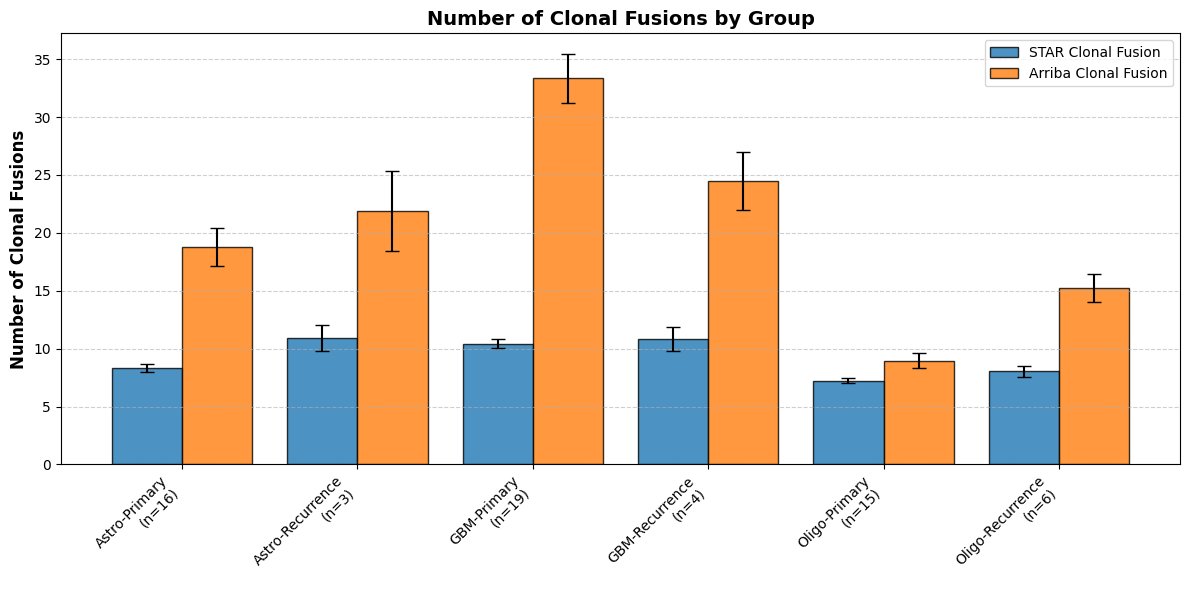

In [5]:
from fcg import analysis_functions
importlib.reload(analysis_functions)

# Define measures and run analysis
measures = {
    "STAR": "STAR_clonal_in_sample",
    "Arriba": "Arriba_clonal_in_sample"
}
analysis_functions.analyze_and_plot(metadata_unique, measures)

/costellolab/data3/sermare/biopython/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/costellolab/data3/sermare/biopython/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 22.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


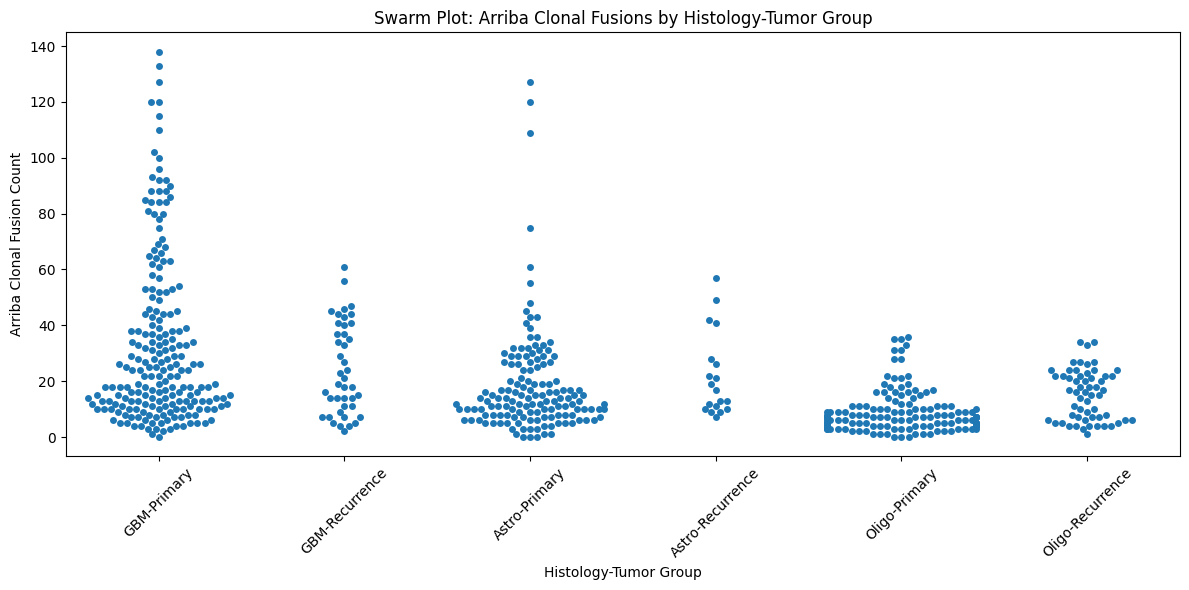

In [6]:
plt.figure(figsize=(12, 6))
sns.swarmplot(x='Histology_Tumor', y='Arriba_clonal_in_sample', data=metadata_unique)
plt.title("Swarm Plot: Arriba Clonal Fusions by Histology-Tumor Group")
plt.xlabel("Histology-Tumor Group")
plt.ylabel("Arriba Clonal Fusion Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Kruskal–Wallis test for Arriba Clonal Fusion across groups:
  H-statistic = 132.1773, p-value = 8.212e-27

No significant differences for Arriba Clonal Fusion; skipping pairwise comparisons.


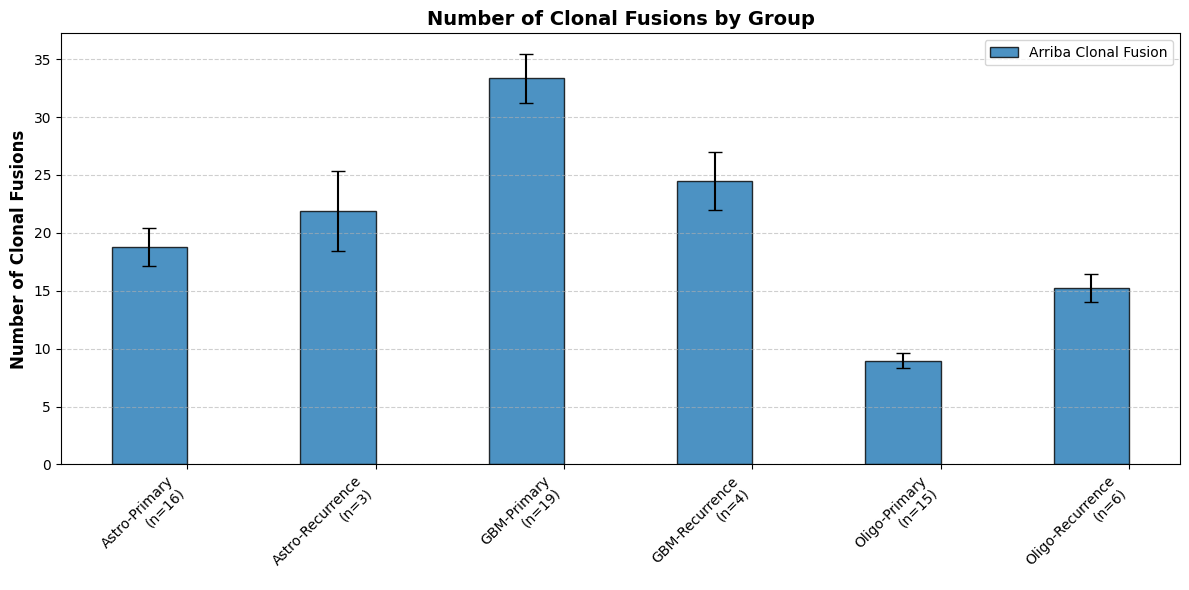

In [7]:
measures = {
    "Arriba": "Arriba_clonal_in_sample"
}
analysis_functions.analyze_and_plot(metadata_unique, measures)

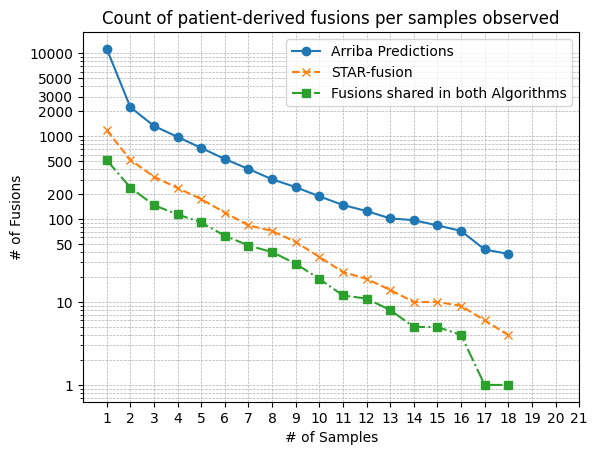

In [8]:
threshold_values = range(0, 18)  # Values from 0 to 17
counts_arriba = []
counts_star = []
counts_common = []

for threshold in threshold_values:
    count_arriba = set(final_df[final_df['arriba_hg38'] > threshold]['fg_bk'].unique())
    counts_arriba.append(len(count_arriba))
    
    count_star = set(final_df[final_df['star_hg38'] > threshold]['fg_bk'].unique())
    counts_star.append(len(count_star))

    count_common = len(count_star & count_arriba)
    counts_common.append(count_common)

threshold_results = pd.DataFrame({
    'threshold': threshold_values,
    'counts_arriba': counts_arriba,
    'counts_star': counts_star,
    'counts_common': counts_common
})

plt.plot(threshold_values, counts_arriba, marker='o', linestyle='-', label='Arriba Predictions')
plt.plot(threshold_values, counts_star, marker='x', linestyle='--', label='STAR-fusion')
plt.plot(threshold_values, counts_common, marker='s', linestyle='-.', label='Fusions shared in both Algorithms')
plt.xlabel('# of Samples')
plt.ylabel('# of Fusions')
plt.title('Count of patient-derived fusions per samples observed')
plt.xlim([-1, 20])
plt.yscale('log')

y_ticks = [1, 10, 50, 100, 200, 500, 1000, 2000, 3000, 5000, 10000]  # Adjust these values based on your data range
plt.yticks(y_ticks, labels=[str(int(tick)) for tick in y_ticks])
plt.xticks(range(0, 21), range(1, 22))
plt.xlim([-1,20])

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()

# Show the plot
plt.show()


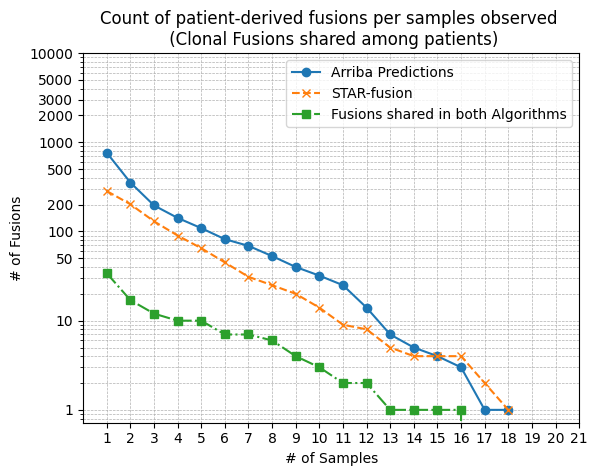

In [9]:
threshold_values = range(0, 18)  # Values from 0 to 17
counts_arriba = []
counts_star = []
counts_common = []

# Calculate counts for each threshold value for both DataFrame columns
for threshold in threshold_values:
    count_arriba = set(final_df[(final_df['arriba_hg38'] > threshold) & (final_df['count_in_other_patients'] > 0)]['fg_bk'].unique())
    counts_arriba.append(len(count_arriba))
    
    count_star = set(final_df[(final_df['star_hg38'] > threshold) & (final_df['count_in_other_patients'] > 0)]['fg_bk'].unique())
    counts_star.append(len(count_star))

    count_common = len(count_star & count_arriba)
    counts_common.append(count_common)

# Combine the results into a DataFrame for visualization or further analysis
threshold_results = pd.DataFrame({
    'threshold': threshold_values,
    'counts_arriba': counts_arriba,
    'counts_star': counts_star,
    'counts_common': counts_common
})

# Create the plot
plt.plot(threshold_values, counts_arriba, marker='o', linestyle='-', label='Arriba Predictions')
plt.plot(threshold_values, counts_star, marker='x', linestyle='--', label='STAR-fusion')
plt.plot(threshold_values, counts_common, marker='s', linestyle='-.', label='Fusions shared in both Algorithms')
plt.xlabel('# of Samples')
plt.ylabel('# of Fusions')
plt.title('Count of patient-derived fusions per samples observed \n (Clonal Fusions shared among patients)')
plt.xlim([-1, 20])
plt.yscale('log')

# Define y-ticks based on the range of your data
y_ticks = [1, 10, 50, 100, 200, 500, 1000, 2000, 3000, 5000, 10000]  # Adjust these values based on your data range
plt.yticks(y_ticks, labels=[str(int(tick)) for tick in y_ticks])
plt.xticks(range(0, 21), range(1, 22))
# plt.xlim([-1,20])

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()

# Show the plot
plt.show()


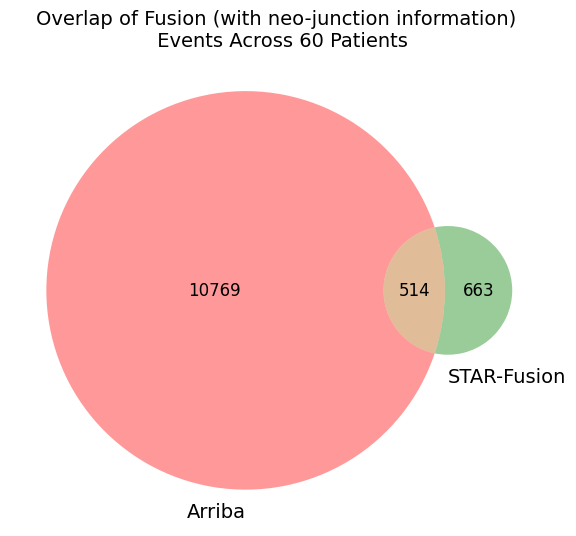

In [ ]:
from matplotlib_venn import venn2

# Extract unique fusion sets per histology type
arriba_fusion_venn = set(arriba38['fg_bk'].unique())
star_fusion_venn = set(star38['fg_bk'].unique())

# Compute fusion categories
exclusive = arriba_fusion_venn - star_fusion_venn
gbm_oligo = arriba_fusion_venn & star_fusion_venn

# Create high-quality Venn diagram
fig, ax = plt.subplots(figsize=(6, 6))

venn = venn2(subsets=((arriba_fusion_venn), (star_fusion_venn)),
             set_labels=('Arriba', 'STAR-Fusion'))

# Customize Venn diagram aesthetics
for text in venn.set_labels:
    if text:
        text.set_fontsize(14)  # Increase label size

for text in venn.subset_labels:
    if text:
        text.set_fontsize(12)  # Increase subset label size

# Set title with professional styling
plt.title("Overlap of Fusion (with neo-junction information) \n Events Across 60 Patients", fontsize=14 )# , fontweight='bold')

# Remove surrounding plot borders
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Show plot
plt.tight_layout()
plt.show()

In [11]:
# Extract relevant data for each histology type
plot_bar_gbm = final_df[
    (final_df['total_observed_multiple_files'] > 1) &
    (final_df['SF#'].isin(metadata_unique[metadata_unique['Histology'] == 'GBM']['SF#']))
][['patient', 'SF#']].groupby('patient').size().reset_index(name='total_clonal_fusions')
plot_bar_gbm['Histology'] = 'GBM'

plot_bar_oligo = final_df[
    (final_df['total_observed_multiple_files'] > 1) &
    (final_df['SF#'].isin(metadata_unique[metadata_unique['Histology'] == 'Oligo']['SF#']))
][['patient', 'SF#']].groupby('patient').size().reset_index(name='total_clonal_fusions')
plot_bar_oligo['Histology'] = 'Oligo'

plot_bar_astro = final_df[
    (final_df['total_observed_multiple_files'] > 1) &
    (final_df['SF#'].isin(metadata_unique[metadata_unique['Histology'] == 'Astro']['SF#']))
][['patient', 'SF#']].groupby('patient').size().reset_index(name='total_clonal_fusions')
plot_bar_astro['Histology'] = 'Astro'

# Combine data
plot_bar_combined = pd.concat([plot_bar_gbm, plot_bar_astro, plot_bar_oligo])


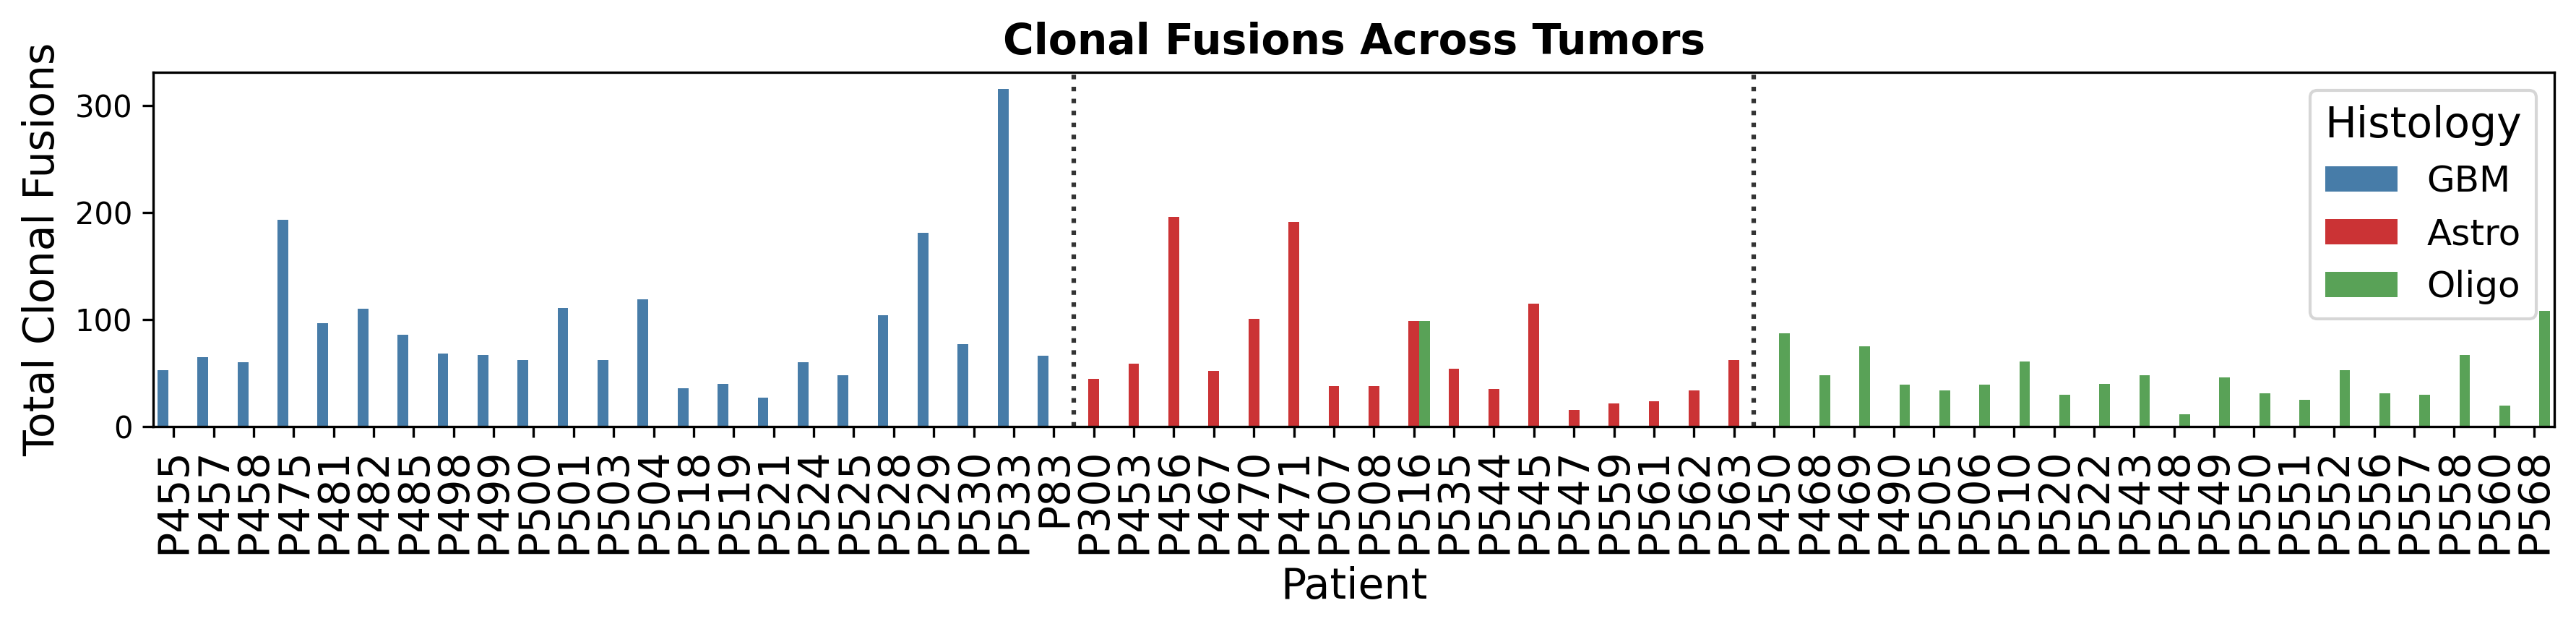

In [12]:
# Use colors from Seaborn's Set1 palette for GBM (blue), Astro (red), and Oligo (green)
set1_colors = sns.color_palette("Set1", 3)
custom_palette = {"GBM": set1_colors[1], "Astro": set1_colors[0], "Oligo": set1_colors[2]}

# Ensure the patient column is sorted within each histology category in the desired order: GBM -> Astro -> Oligo
plot_bar_combined['Histology'] = pd.Categorical(
    plot_bar_combined['Histology'], categories=["GBM", "Astro", "Oligo"], ordered=True
)
plot_bar_combined = plot_bar_combined.sort_values(by=['Histology', 'patient'], ascending=[True, True])

# Set up figure with high resolution (dpi=300)
plt.figure(figsize=(12, 3), dpi=300)

# Plot grouped bar chart with custom Set1 colors
sns.barplot(data=plot_bar_combined, x='patient', y='total_clonal_fusions', hue='Histology', palette=custom_palette)

# Add vertical separators for different histology types
gbm_end = len(plot_bar_gbm) - 0.5
astro_end = gbm_end + len(plot_bar_astro)
plt.axvline(gbm_end, linestyle="dotted", color="black", alpha=0.8)
plt.axvline(astro_end, linestyle="dotted", color="black", alpha=0.8)

# Customize plot aesthetics
plt.title('Clonal Fusions Across Tumors', fontsize=14, fontweight='bold')
plt.ylabel('Total Clonal Fusions', fontsize=14)
plt.xlabel('Patient', fontsize=14)
plt.xticks(rotation=90, fontsize=14)
plt.legend(title="Histology", fontsize=12, title_fontsize=14)

# Adjust layout for better readability
plt.tight_layout()

# Display the high resolution plot
plt.show()


/scratch/sermare/ipykernel_2898449/4159978680.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  spanning_frag_count = spanning_frag_count.loc[common_fusions_2]
/scratch/sermare/ipykernel_2898449/4159978680.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ffpm_values_2 = ffpm_values_2.loc[common_fusions_2]


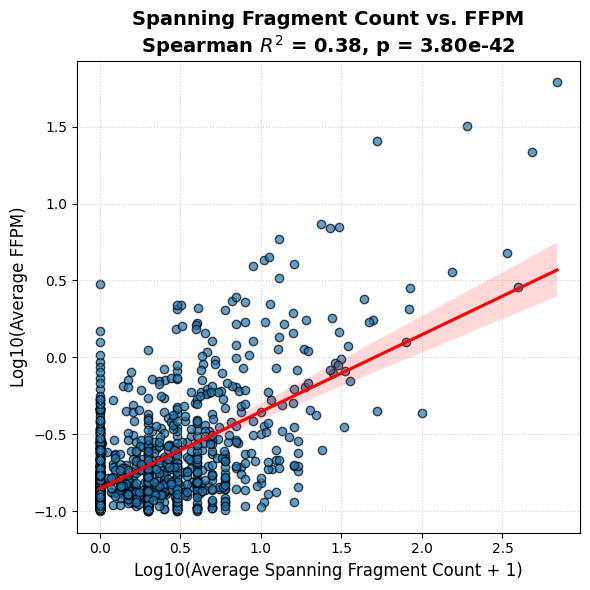

In [13]:
from scipy.stats import spearmanr

# --- Regression plot for SpanningFragCount vs. FFPM ---

# Compute log-transformed averages for SpanningFragCount and FFPM
spanning_frag_count = (
    star38.groupby('fg_bk')['SpanningFragCount']
    .mean()
    .add(1)  # Avoid log(0)
    .apply(np.log10)
)

ffpm_values_2 = (
    star38.groupby('fg_bk')['FFPM']
    .mean()
    .apply(np.log10)
)

# Ensure both datasets have the same fusion genes
common_fusions_2 = set(spanning_frag_count.index) & set(ffpm_values_2.index)
spanning_frag_count = spanning_frag_count.loc[common_fusions_2]
ffpm_values_2 = ffpm_values_2.loc[common_fusions_2]

# Compute Spearman correlation
spearman_corr_2, spearman_pval_2 = spearmanr(spanning_frag_count.values, ffpm_values_2.values)

# Create regression plot
plt.figure(figsize=(6, 6))
sns.regplot(x=spanning_frag_count, y=ffpm_values_2, scatter_kws={'alpha': 0.7, 'edgecolor': 'black'}, line_kws={"color": "red"})

# Customize plot aesthetics
plt.title(f'Spanning Fragment Count vs. FFPM\nSpearman $R^2$ = {spearman_corr_2:.2f}, p = {spearman_pval_2:.2e}', fontsize=14, fontweight='bold')
plt.xlabel('Log10(Average Spanning Fragment Count + 1)', fontsize=12)
plt.ylabel('Log10(Average FFPM)', fontsize=12)
plt.grid(True, linestyle='dotted', alpha=0.6)

# Adjust layout
plt.tight_layout()
plt.show()


/scratch/sermare/ipykernel_2898449/2639726689.py:26: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  discordant_mates = discordant_mates.loc[common_fusions]
/scratch/sermare/ipykernel_2898449/2639726689.py:27: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ffpm_values = ffpm_values.loc[common_fusions]


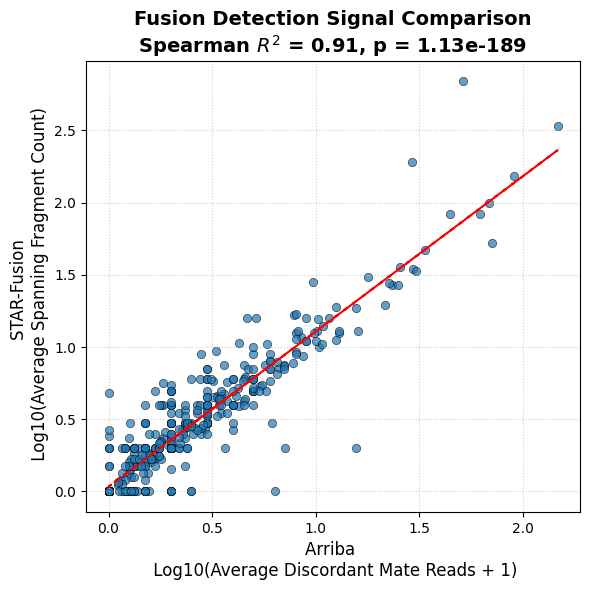

In [14]:
# Extract fusion genes that appear in more than one algorithm
fusion_genes = final_df[final_df['total_algorithms'] > 1]['fg_bk'].values

# Get average discordant mates per unique fusion gene
discordant_mates = (
    arriba38[arriba38['fg_bk'].isin(fusion_genes)]
    .groupby('fg_bk')['discordant_mates']
    .mean()
)

# Get FFPM values per unique fusion gene
ffpm_values = (
    star38[star38['fg_bk'].isin(fusion_genes)]
    .groupby('fg_bk')['SpanningFragCount']
    .mean()
)

ffpm_values = ffpm_values + 1
ffpm_values = ffpm_values.apply(np.log10) 

discordant_mates = discordant_mates + 1
discordant_mates = discordant_mates.apply(np.log10) 

# Ensure both datasets have the same fusion genes
common_fusions = set(discordant_mates.index) & set(ffpm_values.index)
discordant_mates = discordant_mates.loc[common_fusions]
ffpm_values = ffpm_values.loc[common_fusions]

# Compute Spearman correlation
spearman_corr, spearman_pval = spearmanr(discordant_mates.values, ffpm_values.values)

# Create scatter plot with corrected axis labels
plt.figure(figsize=(6, 6))
sns.scatterplot(x=discordant_mates, y=ffpm_values, alpha=0.7, edgecolor='black')

# Compute Spearman correlation
spearman_corr, spearman_pval = spearmanr(discordant_mates.values, ffpm_values.values)

discordant_mates = discordant_mates.dropna()
ffpm_values = ffpm_values.dropna()

m, b = np.polyfit(discordant_mates, ffpm_values, 1)
plt.plot(discordant_mates, m * discordant_mates + b, color='red', linestyle="dashed")


# Customize plot aesthetics
plt.title(f'Fusion Detection Signal Comparison\nSpearman $R^2$ = {spearman_corr:.2f}, p = {spearman_pval:.2e}', fontsize=14, fontweight='bold')
plt.xlabel('Arriba \n Log10(Average Discordant Mate Reads + 1)', fontsize=12)
plt.ylabel('STAR-Fusion \n Log10(Average Spanning Fragment Count)', fontsize=12)
plt.grid(True, linestyle='dotted', alpha=0.6)

# Adjust layout
plt.tight_layout()
plt.show()



In [15]:
heatmap_data = pd.read_csv('/c4/home/sermare/jupyter-notebooks/HEATMAP_FUSION_DATA.csv')
heatmap_data.set_index('Unnamed: 0', inplace=True)


In [16]:
heatmap_data["Total_Count"] = (heatmap_data.iloc[:, 1:] > 0).sum(axis=1)
heatmap_data_sorted = heatmap_data.sort_values(by="Total_Count", ascending=False)
heatmap_data_sorted = heatmap_data_sorted.iloc[:, :-1]

In [17]:
from fcg import plots
importlib.reload(plots)

<module 'fcg.plots' from '/c4/home/sermare/fusioncharacterization_gliomas/fcg/plots.py'>

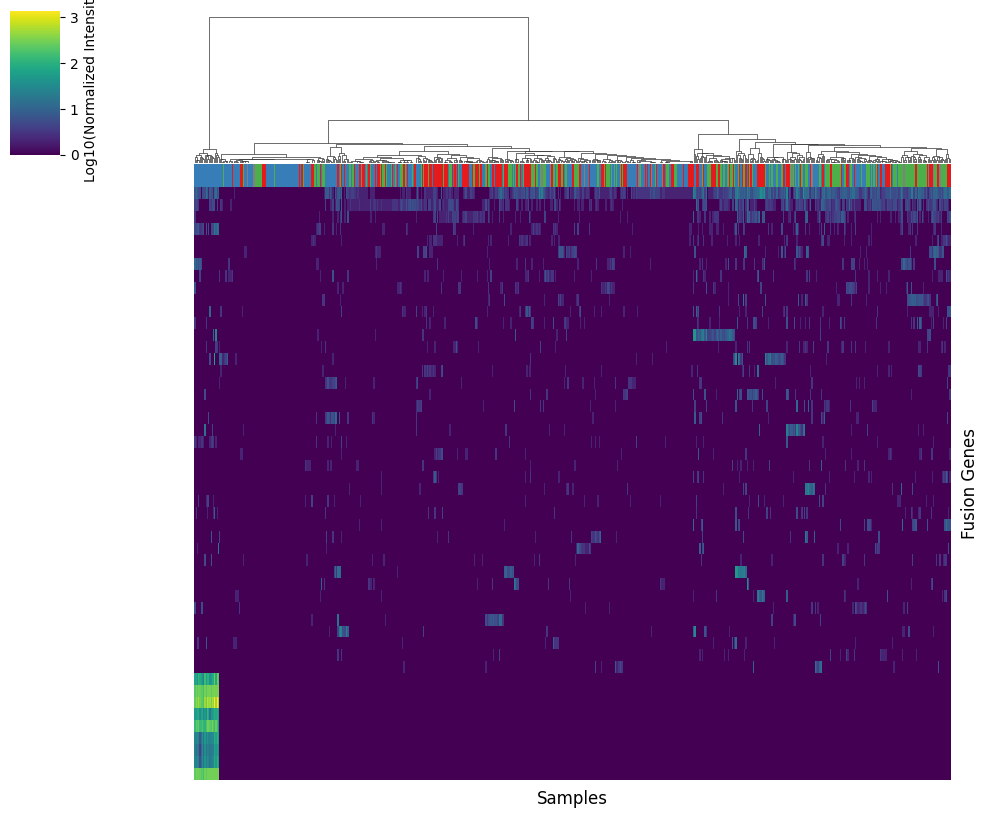

In [18]:
g = plots.create_custom_clustermap(heatmap_data_sorted, metadata, n_top=50)

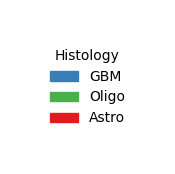

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

legend_handles = [mpatches.Patch(color=custom_palette[h], label=h) for h in ['GBM', 'Oligo', 'Astro']]

fig, ax = plt.subplots(figsize=(2, 2))
legend = ax.legend(handles=legend_handles, title="Histology", loc="center", frameon=False)
ax.axis("off")
plt.show()


<AxesSubplot: >

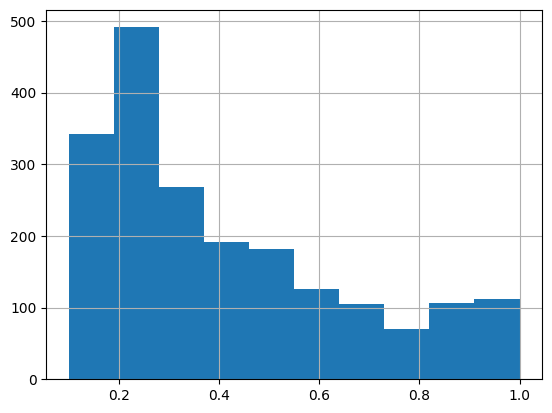

In [20]:
final_df[(final_df['total_observed_multiple_files'] > 1 ) 
            & (final_df['count_in_other_patients'] == 0)
            ]['normalized_total_observed'].hist()

<AxesSubplot: >

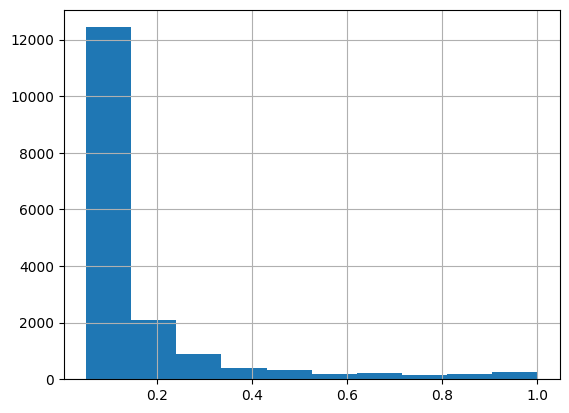

In [21]:
final_df['normalized_total_observed'].hist()